In [1]:
%load_ext load_style
%load_style talk.css

# GPCP(MONTHLY)

This notebook presents a primary analysis of monthly GCPCP precipitation data from 1979 to 2010:
* Trend
* Climatological annual mean precipitation
* Areal weighted mean of precipitation rate 
* Zonal mean precipitation

**Data**

The monthly GPCP(GLOBAL PRECIPITATION CLIMATOLOGY PROJECT) data have merged rain from gauge stations, satellites, and sounding observations to estimate monthly rainfall on a 2.5-degree global grid from 1979 to the present. More information can be found at https://climatedataguide.ucar.edu/climate-data/gpcp-monthly-global-precipitation-climatology-project.

## 1. Import basic libraries

In [2]:
% matplotlib inline

from pylab import *
import numpy as np
import scipy.stats as stats
import datetime 

from netCDF4 import netcdftime
from netCDF4 import Dataset as netcdf # netcdf4-python module
from netcdftime import utime

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
import matplotlib.ticker as ticker

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import warnings
warnings.simplefilter('ignore')

## 2. Read monthly precipitation data

### 2.1 Read data

In [3]:
infile = r'data\V22_GPCP.1979-2010.nc'
ncset     = netcdf(infile)
ncset.set_auto_mask(False)
lons   = ncset['lon'][:]
lats   = ncset['lat'][:]
nctime = ncset['time'][:]
t_unit = ncset['time'].units
pr     = ncset['PREC'][:]

try :
    t_cal = ncset['time'].calendar
except AttributeError : # Attribute doesn't exist
    t_cal = u"gregorian" # or standard

undef = -99999.0
pr[pr==undef] = np.nan

nt,nlat,nlon = pr.shape
ngrd = nlat*nlon

### 2.2 Parse times

In [4]:
utime   = netcdftime.utime(t_unit, calendar = t_cal)
datevar = utime.num2date(nctime)

datevar[0:5]

array([datetime.datetime(1979, 1, 16, 0, 0),
       datetime.datetime(1979, 2, 14, 0, 0),
       datetime.datetime(1979, 3, 16, 0, 0),
       datetime.datetime(1979, 4, 15, 0, 0),
       datetime.datetime(1979, 5, 16, 0, 0)], dtype=object)

## 3. Trend analysis

### 3.1 Calculate Trend

In [5]:
pr_grd  = pr.reshape((nt, ngrd), order='F') 

pr_rate = np.empty((ngrd,1))
pr_rate[:,:] = np.nan
pr_val = np.empty((ngrd,1))
pr_val[:,:] = np.nan

for i in range(ngrd): 
    y = pr_grd[:,i]  
    y0 = y[~np.isnan(y)]    
   
    x = np.linspace(1,len(y0), len(y0))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y0)
    pr_rate[i,0] = slope*120.0  
    pr_val[i,0]  = p_value 
    
pr_rate = pr_rate.reshape((nlat,nlon), order='F')
pr_val  = pr_val.reshape((nlat,nlon), order='F')

#pr_rate = np.ma.masked_array(pr_rate, mask=(pr_val<0.05))

### 3.2 Visualize trend

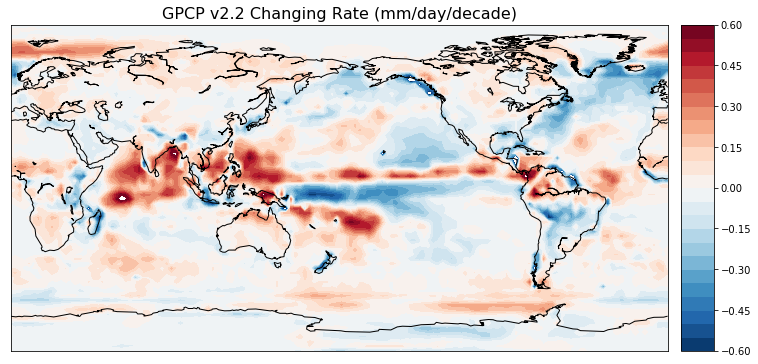

In [6]:
m = Basemap(projection='cyl', llcrnrlon=min(lons), llcrnrlat=min(lats),
        urcrnrlon=max(lons), urcrnrlat=max(lats))

x, y = m(*np.meshgrid(lons, lats))
clevs = np.linspace(-0.6, 0.6, 25)
cs = m.contourf(x, y, pr_rate.squeeze(), clevs, cmap=plt.cm.RdBu_r)
m.drawcoastlines()

cb = m.colorbar(cs)
plt.title('GPCP v2.2 Changing Rate (mm/day/decade)', fontsize=16)

## 4. Climatological annual mean precipitation

In [7]:
pr_ann_clm  = np.nanmean(pr, axis=0)

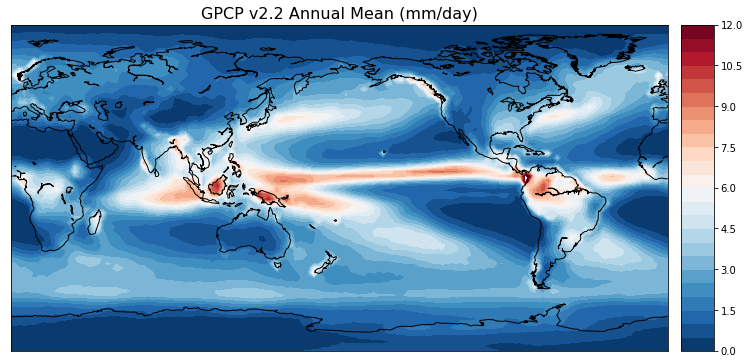

In [8]:
m = Basemap(projection='cyl', llcrnrlon=min(lons), llcrnrlat=min(lats),
        urcrnrlon=max(lons), urcrnrlat=max(lats))

x, y = m(*np.meshgrid(lons, lats))
clevs = np.linspace(0.0, 12.0, 25)
cs = m.contourf(x, y, pr_ann_clm.squeeze(), clevs, cmap=plt.cm.RdBu_r)
m.drawcoastlines()

cb = m.colorbar(cs)
plt.title('GPCP v2.2 Annual Mean (mm/day)', fontsize=16)

## 5. Areal weighted mean of precipitation rate

### 5.1 Calculate areal weighted mean

In [9]:
lonx, latx = np.meshgrid(lons, lats)
weights = np.cos(latx * np.pi / 180.)

pr_glb_avg = np.zeros(nt)

for it in np.arange(nt):
    pone = pr[it,:, :]
    pone = np.ma.masked_array(pone, mask=np.isnan(pone))
    pr_glb_avg[it] = np.average(pone, weights=weights) 
    
glb_avg = np.mean(pr_glb_avg)
print(glb_avg)

2.6742099716


### 5.2 Visualize areal weighted mean

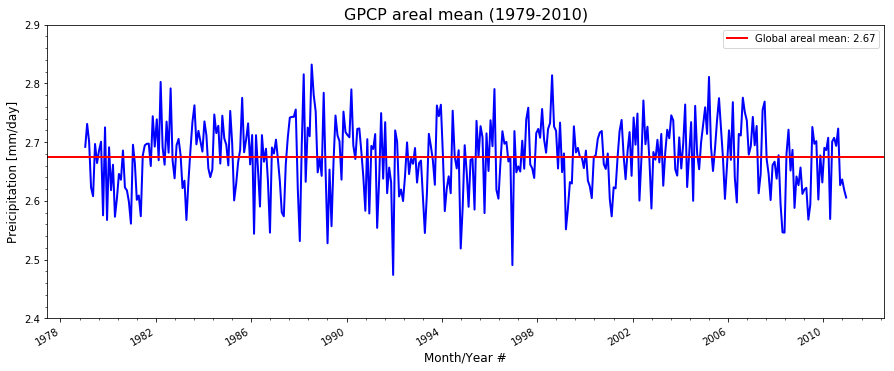

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))

ax.plot(datevar, pr_glb_avg, color='b', linewidth=2)

ax.axhline(glb_avg, linewidth=2, color='r', label="Global areal mean: " + str(np.round(glb_avg*100)/100))
ax.legend()
ax.set_title('GPCP areal mean (1979-2010)', fontsize=16)
ax.set_xlabel('Month/Year #', fontsize=12)
ax.set_ylabel('Preicipitation [mm/day]', fontsize=12)
ax.set_ylim(2.4, 2.9)
ax.minorticks_on()

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y')

## 6. Zonal mean precipitation

In [11]:
pr_ann_clm   = np.nanmean(pr, axis=0)
pr_ann_zonal = np.nanmean(pr_ann_clm, axis=1)

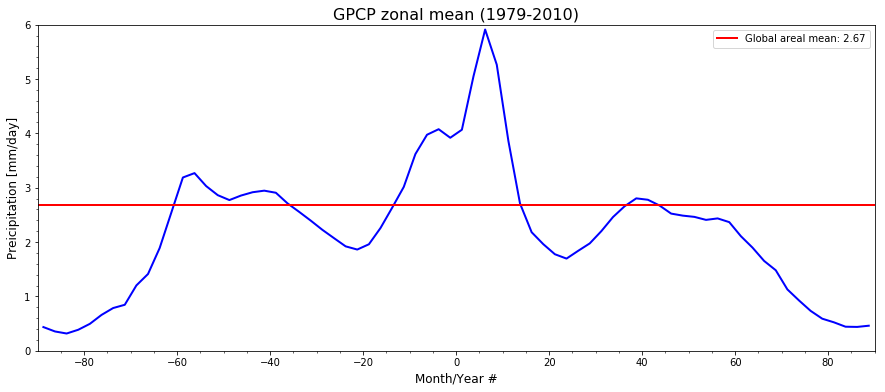

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))

ax.plot(lats, pr_ann_zonal, color='b', linewidth=2)

ax.axhline(glb_avg, linewidth=2, color='r', label="Global areal mean: " + str(np.round(glb_avg*100)/100))
ax.legend()
ax.set_title('GPCP zonal mean (1979-2010)', fontsize=16)
ax.set_xlabel('Month/Year #', fontsize=12)
ax.set_ylabel('Preicipitation [mm/day]', fontsize=12)
ax.set_ylim(0.0, 6.0)
ax.set_xlim(-90, 90)
ax.minorticks_on()

## References

http://unidata.github.io/netcdf4-python/

Matplotlib: A 2D Graphics Environment by J. D. Hunter In Computing in Science & Engineering, Vol. 9, No. 3. (2007), pp. 90-95

Jones E, Oliphant E, Peterson P, et al. SciPy: Open Source Scientific Tools for Python, 2001-, http://www.scipy.org/

Pendergrass, Angeline & National Center for Atmospheric Research Staff (Eds). Last modified 02 Jul 2016. "The Climate Data Guide: GPCP (Monthly): Global Precipitation Climatology Project." Retrieved from https://climatedataguide.ucar.edu/climate-data/gpcp-monthly-global-precipitation-climatology-project.